In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
def load_data(trace_path):
    with open(trace_path) as json_file:
        json_data = json.load(json_file)

        return json_data

        events = json_data['traceEvents']

        cuda_events = []
        wall_times = []
        timestamps = []

        for event in events:
            if 'stream' in str(event['tid']) and \
                    'name' in event.keys() and \
                    'dur' in event.keys() and \
                    event['cat'] == 'Kernel':
                cuda_events.append(event)
                # print(f"{event['ts']}: {event['dur']}")

                wall_times.append(event['dur'])
                timestamps.append(event['ts'])

        kernel_names = []
        kernel_sum_dur = {}
        kernel_count = {}
        for event in cuda_events:
            kernel_names.append(event['name'])
            kernel_sum_dur[event['name']] = 0
            kernel_count[event['name']] = 0

        kernel_names = np.unique(kernel_names)

        for i in range(len(kernel_names)):
            name = kernel_names[i]
            # print(f'{i}: {kernel_names[i]}')

        for event in cuda_events:
            kernel_sum_dur[event['name']] += event["dur"]
            kernel_count[event['name']] += 1

        for event in cuda_events:
            kernel_sum_dur[event['name']] /= kernel_count[event['name']]


        return {
            "wall_times": wall_times,
            "timestamps": timestamps,
            "kernel_names": kernel_names,
            "kernel_count": kernel_count,
            "kernel_info": kernel_sum_dur
        }

In [3]:
def draw_fixed_model(info):
    profiled_infos = []
    model = info["model"]

    for gpu in info["gpus"]:
        profiled_infos.append({
            "data": load_data(f"{gpu}-{model}-batch-test.json"),
            "gpu": gpu,
        })

    datas = []

    for info in profiled_infos:
        datas.append(info)
        
    print(len(datas[0]["data"]["elapsed_time"]["batch_sizes"]))

    plt.title(f"{model}")
    ax = plt.subplot(111)
    ax.set_xlabel("batch size")
    ax.set_ylabel("iteration time (ms)")
    for data in datas:
        ax.plot(data["data"]["elapsed_time"]["batch_sizes"],
                data["data"]["elapsed_time"]["iteration_sum"],
                #data["data"]["elapsed_time"]["forward"],
                '-',
                #color='steelblue',
                label=data["gpu"])

    ax.legend()
    plt.savefig(f"{model}-batch-sizes-analysis.png", dpi=400)

32


<ipython-input-22-73a3042e96d5>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


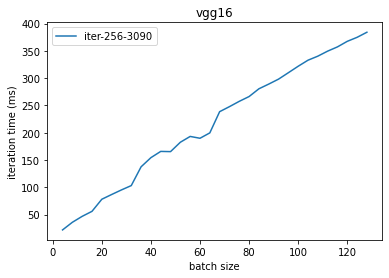

In [23]:
info = {
    "gpus": ["iter-256-3090"],
    "model": "vgg16",
}

draw_fixed_model(info)

In [4]:
def draw_preproc_ett(config):
    with open(config["file-path"], "r") as f:
        data = json.load(f)
        print(f"[data keys]")
        for key in data.keys():
            print(f"{key}")
        print()
            
        print(f"[result keys]")
        for result in data["results"]:
            for key in result.keys():
                print(f"{key}")
            break
        print()
            
        batch_count = data["batch-count"]
        batch_sizes = data["batch-sizes"]
        num_workers = data["num_workers"]
        for i in range(len(batch_sizes)):
            print(f"batch size: {batch_sizes[i]}")
            result = data["results"][i]
            ett = result["ett"]
            dataset = data["dataset"]
            plt.title(f"{dataset}")
            ax = plt.subplot(111)
            ax.set_xlabel("mini-batches")
            ax.set_ylabel("preprocess time (ms)")
            length = int(len(ett) * 1.0)
            ax.plot([i for i in range(length)],
                    ett[:length],
                    #sorted(ett)[:length],
                    #data["data"]["elapsed_time"]["forward"],
                    '-',
                    #color='steelblue',
                    #label=data["gpu"],
                   )

            ax.legend()
            plt.savefig(f"{dataset}-workers-{num_workers}-batch-{batch_sizes[i]}.png", dpi=400)
            plt.clf()

In [5]:
config = {
    "file-path": "output-workers-40.json"
}

draw_preproc_ett(config)

<ipython-input-4-0ced0fc73786>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)
No handles with labels found to put in legend.


[data keys]
dataset
num_workers
image_size
batch-count
batch-sizes
results

[result keys]
ett
min
max
mean

batch size: 32


<Figure size 432x288 with 0 Axes>

In [7]:
def draw(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
        print(f"[data keys]")
        for key in data.keys():
            print(f"{key}")
        print()
        # return
            
        #print(f"[result keys]")
        #for result in data["results"]:
        #    for key in result.keys():
        #        print(f"{key}")
        #    break
        #print()
            
        #batch_count = data["batch-count"]
        batch_sizes = data["batch-size"]
        #num_workers = data["num_workers"]
        iterations = data["iterations"]
        model_name = data["model-name"]
        ett = data["ett"]
        for key in ett.keys():
            print(f"{key}")
        print()
        
        ett = data["ett"]
        plt.title(f"{model_name}")
        ax = plt.subplot(111)
        ax.set_xlabel("mini-batches")
        ax.set_ylabel("elapsed time (ms)")
        
        skip = int(iterations * 0.1)
        x = [i for i in range(iterations - skip)]
        
        y_labels = ["batch-load", "data-copy-to-gpu", "train", "total"]
        #y_labels = ["batch-load", "train"]
        
        for y_label in y_labels:
            ax.plot(x,
                    ett[y_label][skip:],
                    #sorted(ett)[:length],
                    #data["data"]["elapsed_time"]["forward"],
                    '-',
                    #color='steelblue',
                    label=y_label,
                   )

        ax.legend()
        plt.draw()
            #plt.savefig(f"{dataset}-workers-{num_workers}-batch-{batch_sizes[i]}.png", dpi=400)
            #plt.clf()

[data keys]
model-name
iterations
batch-size
ett

unit
batch-load
data-copy-to-gpu
train
total



<ipython-input-7-8376f113f1be>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


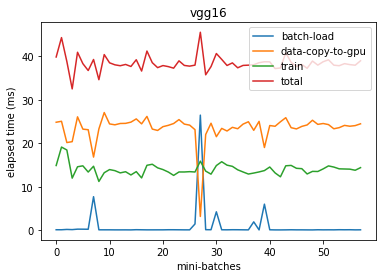

In [14]:
draw("preproc-analysis-vgg16-batch-8.json")